<a href="https://colab.research.google.com/github/JATINKUMAR234/CupidEnvelope.github.io/blob/main/Multi_Scale_CNN(no_alteration).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# STEP 1: Install Kaggle & Upload Your kaggle.json
!pip install -q kaggle

from google.colab import files
uploaded = files.upload()  # upload your kaggle.json here

# STEP 2: Move kaggle.json to ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# STEP 3: Download FER-2013 Dataset from Kaggle
# You must have accepted competition rules first (https://www.kaggle.com/datasets/msambare/fer2013)
!kaggle datasets download -d msambare/fer2013

# STEP 4: Unzip the dataset
!unzip -q fer2013.zip -d fer2013

# STEP 5: Check directory structure
!ls fer2013

# STEP 6: Setup directory paths
import os
data_dir = "/content/fer2013"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

print("✅ Dataset ready at:", data_dir)


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
test  train
✅ Dataset ready at: /content/fer2013


In [10]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense,
                                     Concatenate, Activation, UpSampling2D, AveragePooling2D,
                                     BatchNormalization, Multiply)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (48, 48)
batch_size = 64

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(train_dir, target_size=image_size, color_mode='grayscale', batch_size=batch_size, class_mode='categorical')
test_gen = datagen.flow_from_directory(test_dir, target_size=image_size, color_mode='grayscale', batch_size=batch_size, class_mode='categorical')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:
from tensorflow.keras.layers import Resizing

def pyramid_pooling_module(input_tensor):
    pool_sizes = [1, 2, 4, 8]
    h, w = input_tensor.shape[1], input_tensor.shape[2]
    concat_list = [input_tensor]

    for pool_size in pool_sizes:
        x = AveragePooling2D(pool_size=(pool_size, pool_size))(input_tensor)
        x = Conv2D(64, kernel_size=1, padding='same', activation='relu')(x)

        # Simpler resizing using Keras-native Resizing layer
        x = Resizing(h, w, interpolation='bilinear')(x)

        concat_list.append(x)

    return Concatenate()(concat_list)


In [13]:
def spatial_attention(input_tensor):
    x = Conv2D(1, kernel_size=1, activation='sigmoid')(input_tensor)
    return Multiply()([input_tensor, x])


In [14]:
def build_model(input_shape=(48, 48, 1), num_classes=7):
    inputs = Input(shape=input_shape)

    # Multi-scale feature extraction
    conv3 = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    conv5 = Conv2D(64, (5, 5), padding='same', activation='relu')(inputs)
    conv7 = Conv2D(64, (7, 7), padding='same', activation='relu')(inputs)
    multi_scale = Concatenate()([conv3, conv5, conv7])

    # BatchNorm and pooling
    x = BatchNormalization()(multi_scale)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Dilated Convolution
    dilated = Conv2D(128, (3, 3), dilation_rate=2, padding='same', activation='relu')(x)

    # Pyramid Pooling
    ppm = pyramid_pooling_module(dilated)

    # Spatial Attention
    attention = spatial_attention(ppm)

    # Final layers
    x = GlobalAveragePooling2D()(attention)
    x = Dense(128, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, x)

In [15]:
model = build_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=25,  # adjust as needed
    verbose=1
)



Epoch 1/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.2585 - loss: 1.7953 - val_accuracy: 0.2767 - val_loss: 1.7743
Epoch 2/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.3430 - loss: 1.6562 - val_accuracy: 0.3518 - val_loss: 1.6279
Epoch 3/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.4333 - loss: 1.4591 - val_accuracy: 0.4476 - val_loss: 1.4771
Epoch 4/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.4780 - loss: 1.3640 - val_accuracy: 0.4100 - val_loss: 1.5729
Epoch 5/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.5004 - loss: 1.3085 - val_accuracy: 0.4748 - val_loss: 1.4275
Epoch 6/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.5260 - loss: 1.2545 - val_accuracy: 0.5124 - val_loss: 1.2706
Epoch 7/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.5458 - loss: 1.1945 - val_accuracy: 0.5143 - val_loss: 1.2747
Epoch 8/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.5585 - loss: 1.1637 - 

✅ Training Complete

📊 Loss & Accuracy per Epoch:
        loss  val_loss  accuracy  val_accuracy
0   1.775334  1.774274  0.266989      0.276679
1   1.601223  1.627877  0.369884      0.351769
2   1.438480  1.477059  0.442474      0.447618
3   1.356492  1.572856  0.479362      0.410003
4   1.291580  1.427475  0.508447      0.474784
5   1.240202  1.270634  0.530217      0.512399
6   1.187461  1.274730  0.548957      0.514349
7   1.150450  1.184123  0.564562      0.552382
8   1.106759  1.210400  0.581386      0.549875
9   1.074375  1.216150  0.592602      0.550293
10  1.044840  1.211959  0.605385      0.544720
11  1.006440  1.139225  0.622662      0.575091
12  0.976116  1.159172  0.632972      0.564642
13  0.943742  1.167232  0.647288      0.569518
14  0.916050  1.268675  0.659375      0.551268
15  0.880561  1.177614  0.671775      0.576623
16  0.855092  1.304320  0.685848      0.541934
17  0.811504  1.203268  0.701592      0.557676
18  0.789463  1.139390  0.707339      0.594455
19  0.7563

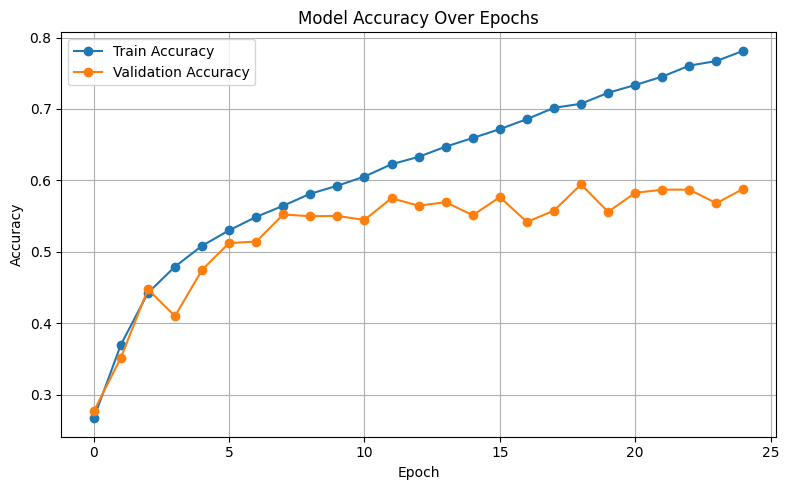

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import time

# Runtime summary
print("✅ Training Complete")

# Table of Loss & Accuracy
history_df = pd.DataFrame(history.history)
print("\n📊 Loss & Accuracy per Epoch:")
print(history_df[['loss', 'val_loss', 'accuracy', 'val_accuracy']])

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
